- 01_matmul
- 02_fully_connected
- 02a_why_sqrt5
- 02b_initialization
- 03_minibatch_training

Table of contents
1. Initial Setup
2. Basic training Loop
3. Using parameters and optim
4. Dataset and DataLoader
5. Validation

# 1. Initial Setup

## Data

### Fastai for Colab env

In [1]:
!git clone http://github.com/fastai/course-v3.git

Cloning into 'course-v3'...
remote: Enumerating objects: 5498, done.
remote: Total 5498 (delta 0), reused 0 (delta 0), pack-reused 5498
Receiving objects: 100% (5498/5498), 257.94 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (2992/2992), done.


In [2]:
%cd course-v3/nbs/dl2

/content/course-v3/nbs/dl2


In [3]:
from exp.nb_02 import *

In [ ]:
!cat exp/nb_02.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/02_fully_connected.ipynb

from exp.nb_01 import *

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"

from torch.nn import init

def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

from torch import nn

### import data

In [4]:
train_x, train_y, valid_x, valid_y = get_data()

In [ ]:
train_x.shape, train_x.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [5]:
n_in, nh, n_out = train_x.shape[1], 32, train_y.max().item()+1; n_in, nh, n_out

(784, 32, 10)

[^12]

[^1]

In [86]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x
    # def forward(self, x, y):
    #     for l in self.layers: x = l(x)
    #     return(self.loss(x, y))

In [87]:
m = Model(n_in, nh, n_out)

In [88]:
[(i,v) for i, v in m.named_parameters()]

[]

In [ ]:
y_hat = m(train_x)

## Loss Function

### Softmax

* formula of softmax : $f(x) = \frac{exp(x)}{\sum exp(x_i)}$
* We need softmax at last layer since we have to map it to the probabilistic space
* code of softmax is below

In [ ]:
def softmax(x): return x.exp() / x.exp().sum(-1, keepdim=True)
# def softmax(x): return x.exp() / x.exp().sum()

[^2]

In [ ]:
p = softmax(y_hat); p[0].sum()

tensor(1., grad_fn=<SumBackward0>)

- I need *log* of softmax because we will use cross-entropy which has form of $H(X, q) = H(X) + D(p|q) = - \sum_{x} p(x)\  log\ q(x)$ [^3]

In [ ]:
def log_softmax(x): return x.exp() / x.exp().sum(-1, keepdim=True)

In [ ]:
a = log_softmax(y_hat)

### Cross Entropy

- see the footnote 3 regarding further information of cross entropy
- One possible reason is because an information theory is based on descrete and determinate value

### Negative log likelihood function

In [ ]:
def nll(x, y): return -x[range(x.shape[0]), y].mean() #x: prediction, y:target 

In [ ]:
nll(y_hat, train_y)

tensor(0.0017, grad_fn=<NegBackward>)

- Negative value is related to entropy, roughly variable which is rare is meaningful [^4]

### LogSumExp

- Further tasks (after reading sum refs) [^5]

In [ ]:
def log_softmax(x): return x - x.logsumexp(-1, keepdim=True)

In [ ]:
test_near(log_softmax(y_hat), a)

AssertionError: ignored

# 2. Basic Training Loop

### 1.  

First, get the prediction (i.e. output) from the model<br/>
Second, get a loss value with prediction and target<br/>
Third, get a gradients<br/>
Fourth, update parameter using gradients, hyperparams<br/>

### 2.

In [7]:
def accuracy(out, trg): return (torch.argmax(out, dim=-1) == trg).float().mean()

### 3

In [8]:
bs = 64

In [9]:
xb, yb = train_x[:bs], train_y[:bs]

In [ ]:
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
m = Model(n_in, nh, n_out); pred = m(xb)

In [ ]:
accuracy(pred, yb)

tensor(0.0781)

In [ ]:
del m, pred, xb, yb
import gc
gc.collect()

600

### 4

In [ ]:
n_in, nh, n_out

(784, 32, 10)

In [11]:
epochs = 1
lr = 0.5

In [ ]:
n = train_x.shape[0]

In [10]:
import torch.nn.functional as F
loss_fun = F.cross_entropy

In [ ]:
def fit():
    # init model to keep memory, gradients,...etc
    model = Model(n_in, nh, n_out)
    for epoch in range(epochs):
        for i in range((n-1)//bs +1): # [^6]
            srt, end = bs*i, bs*(i+1)
            xb, yb = train_x[srt:end], train_y[srt:end]
            loss = loss_fun(model(xb), yb)
            loss.backward()
            with torch.no_grad(): # [^8]
                for l in model.layers:
                    if hasattr(l, 'weight'): # [^7]
                        l.weight -= l.weight.grad * lr
                        l.bias -= l.bias.grad * lr
                        l.weight.grad.zero_() # [^8]
                        l.bias.grad.zero_()
    return model

In [ ]:
m=fit()

In [12]:
xb, yb = train_x[:64], train_y[:64]

In [ ]:
loss_fun(m(xb), yb), accuracy(m(xb), yb)

(tensor(0.1746, grad_fn=<NllLossBackward>), tensor(0.9375))

# 3. Using parameters and optimal

## Parameters

### 1. Re-define model using nn.Module

In [89]:
# [^10]
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in, nh)
        self.l2 = nn.Linear(nh, n_out)
    def __call__(self, inp):
        return self.l2(F.relu(self.l1(inp)))

In [90]:
model = Model(n_in, nh, n_out)

In [15]:
model(train_x)

tensor([[-0.0961,  0.2724, -0.0945,  ...,  0.0623,  0.0917,  0.0012],
        [-0.0293,  0.1502, -0.0897,  ...,  0.0503,  0.0137,  0.0230],
        [ 0.0341,  0.1869, -0.0146,  ...,  0.0239,  0.0517,  0.0880],
        ...,
        [ 0.0330,  0.1831, -0.1755,  ...,  0.0696, -0.0377,  0.0496],
        [-0.0426,  0.2056, -0.0845,  ...,  0.0192,  0.0120,  0.0798],
        [-0.0454,  0.1567, -0.0712,  ...,  0.0363,  0.0298, -0.0153]],
       grad_fn=<AddmmBackward>)

In [91]:
[(i, v) for i, v in model.named_parameters()]

[('l1.weight', Parameter containing:
  tensor([[ 0.0186, -0.0328,  0.0301,  ...,  0.0005, -0.0151,  0.0147],
          [ 0.0327, -0.0081,  0.0304,  ..., -0.0073, -0.0331, -0.0279],
          [-0.0302, -0.0013, -0.0276,  ...,  0.0203, -0.0166,  0.0228],
          ...,
          [-0.0028,  0.0140,  0.0253,  ..., -0.0313, -0.0068,  0.0139],
          [ 0.0283,  0.0155, -0.0152,  ..., -0.0325, -0.0024,  0.0294],
          [-0.0092, -0.0202,  0.0305,  ...,  0.0016, -0.0175, -0.0150]],
         requires_grad=True)), ('l1.bias', Parameter containing:
  tensor([-0.0187, -0.0113, -0.0275, -0.0315,  0.0252, -0.0221, -0.0248,  0.0099,
           0.0327,  0.0138, -0.0205, -0.0173, -0.0245,  0.0059,  0.0187,  0.0253,
           0.0123, -0.0293, -0.0302, -0.0250,  0.0342,  0.0259,  0.0007,  0.0189,
           0.0327, -0.0311, -0.0343, -0.0215,  0.0144, -0.0047, -0.0228, -0.0276],
         requires_grad=True)), ('l2.weight', Parameter containing:
  tensor([[-0.0324,  0.0295,  0.1261, -0.0178,  0.0725

- Difference
0. Didn't stack layers in one container
1. Inherited from nn.Module
2. used ReLU as functional, rather than making it layer

### 2. nn.module,name_children

In [16]:
[f"{name}: {layer}" for name, layer in model.named_children()]

['l1: Linear(in_features=784, out_features=32, bias=True)',
 'l2: Linear(in_features=32, out_features=10, bias=True)']

In [17]:
model.l1 #we can see values from the key

Linear(in_features=784, out_features=32, bias=True)

In [33]:
[i for i in model.l1.parameters()]

[Parameter containing:
 tensor([[-0.0300,  0.0253,  0.0085,  ..., -0.0247,  0.0232,  0.0345],
         [ 0.0279,  0.0283,  0.0356,  ...,  0.0138, -0.0221,  0.0279],
         [ 0.0112, -0.0039, -0.0204,  ...,  0.0141,  0.0340,  0.0212],
         ...,
         [ 0.0209,  0.0137, -0.0065,  ..., -0.0006,  0.0343,  0.0214],
         [ 0.0328,  0.0117, -0.0111,  ...,  0.0065, -0.0196,  0.0127],
         [ 0.0269,  0.0023,  0.0300,  ...,  0.0049,  0.0136,  0.0310]],
        requires_grad=True), Parameter containing:
 tensor([-0.0020,  0.0257, -0.0174, -0.0026, -0.0267, -0.0209, -0.0265,  0.0125,
         -0.0185, -0.0341,  0.0343, -0.0306,  0.0104, -0.0223,  0.0034,  0.0107,
          0.0163,  0.0094, -0.0101,  0.0136, -0.0335, -0.0309, -0.0290,  0.0246,
         -0.0178,  0.0146,  0.0299, -0.0130, -0.0089,  0.0166,  0.0300,  0.0150],
        requires_grad=True)]

In [ ]:
dir(model.l1)

In [19]:
help(model.l1.__setattr__)

Help on method __setattr__ in module torch.nn.modules.module:

__setattr__(name, value) method of torch.nn.modules.linear.Linear instance
    Implement setattr(self, name, value).



### 2. fit function second

In [20]:
def fit():
    model = Model(n_in, nh, n_out)
    for epoch in range(epochs):
        for i in range((n-1)//bs +1):
            srt, end = bs*i, bs*(i+1)
            xb, yb = train_x[srt:end], train_y[srt:end]
            loss = loss_fun(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for param in model.parameters(): param-= param.grad * lr # [^9]
                model.zero_grad()
    return model

- What changed?/ why shorter?

1. this time we make zero grad to model, not each layer
2. don't need the code that checks if they have weight(i.e. parameter), since we already selected parameters in model

In [24]:
n=train_x.shape[0]
m = fit()

loss_fun(m(xb), yb), accuracy(m(xb), yb)

(tensor(0.1523, grad_fn=<NllLossBackward>), tensor(0.9375))

### DummyModule class to simulate pytorch's `__setattr__`

In [32]:
'abrigaie'.startswith("b"), 'abrigaie'.startswith("a")

(False, True)

In [41]:
class DummyModel():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.linear1 = nn.Linear(n_in, nh)
        self.linear2 = nn.Linear(nh, n_out)
    def __setattr__(self, k, v): # [^13] 
        if not k.startswith('_'): self._modules[k] = v # [^11]
        super().__setattr__(k, v) # [^14]

    def __repr__(self): return f"{self._modules}"

    def parameters(self): # [^13]
        for l in self._modules.values():
            for param in l.parameters(): yield param

1. What does the setattr do here?: (maybe) when you initialize the instance, they set attribute to the submodule, with several condition
    1. How can i check if I defined parameters properly?: call the parameters
1. What does the repr do here?: what to print out

### 5. Call the instance of dummymodule and see repr and shape of parameters in instance


In [42]:
dm = DummyModel(n_in, nh, n_out)

In [43]:
dm # repr

{'linear1': Linear(in_features=784, out_features=32, bias=True), 'linear2': Linear(in_features=32, out_features=10, bias=True)}

In [44]:
[o.shape for o in dm.parameters()]

[torch.Size([32, 784]),
 torch.Size([32]),
 torch.Size([10, 32]),
 torch.Size([10])]

## Registering modules

we can approach defining layers with rendering stacked layers, but we should also register modules (i.e. `add_modules`)

1. Re-define Model class ***(4th Model)***
	1. Use original layers approach
	1. Register the modules

In [45]:
layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)] # [^15]

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = layers
        for idx, l in enumerate(self.layers): self.add_module(f'layer_{idx}', l)
    def __call__(self, x):
        for l in self.layers: x = l(x) 
        return x

2. What is `registering modules`?

adding layers to the module....... but still can't get why we use this


3. See the model instance (i.e. repr)

In [46]:
m = Model()

In [47]:
m

Model(
  (layer_0): Linear(in_features=784, out_features=32, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=32, out_features=10, bias=True)
)

In [55]:
[k for k in m.children()]

[Linear(in_features=784, out_features=32, bias=True),
 ReLU(),
 Linear(in_features=32, out_features=10, bias=True)]

In [ ]:
[k.parameters()[0].shape for k in m.children()]

In [59]:
params = [k.parameters() for k in m.children()];

In [63]:
a,b,c = params[0], params[1], params[2]

a - Linear1, b - ReLU, c - Linear2

and there's no element in ReLU

In [64]:
next(a).shape

torch.Size([32, 784])

In [65]:
next(a).shape

torch.Size([32])

In [66]:
next(a).shape

StopIteration: ignored

In [67]:
next(b).shape #ReLU

StopIteration: ignored

## nn.ModuleList

1. Define class SequentialModel ***(5th Model)***
	1. Use nn.ModuleList

In [68]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [69]:
m = SequentialModel(layers)

2. What does nn.ModuleList do for us?

In [70]:
m

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [74]:
[(i, v) for i, v in m.named_parameters()]

[('layers.0.weight', Parameter containing:
  tensor([[ 0.0156,  0.0018,  0.0095,  ...,  0.0163, -0.0154,  0.0163],
          [-0.0108, -0.0148,  0.0158,  ...,  0.0348, -0.0046, -0.0230],
          [ 0.0134,  0.0082, -0.0097,  ..., -0.0131, -0.0148, -0.0212],
          ...,
          [ 0.0223, -0.0063, -0.0290,  ...,  0.0034,  0.0196,  0.0169],
          [ 0.0082,  0.0315, -0.0330,  ..., -0.0147, -0.0342,  0.0087],
          [ 0.0057, -0.0284,  0.0029,  ..., -0.0110,  0.0097, -0.0222]],
         requires_grad=True)), ('layers.0.bias', Parameter containing:
  tensor([ 0.0180,  0.0223,  0.0285,  0.0128,  0.0309,  0.0078, -0.0285,  0.0139,
           0.0001,  0.0006, -0.0126, -0.0234,  0.0284,  0.0147,  0.0012,  0.0067,
          -0.0286, -0.0312, -0.0334, -0.0089, -0.0105,  0.0046, -0.0181,  0.0166,
           0.0154,  0.0133,  0.0166,  0.0315, -0.0179,  0.0263,  0.0305,  0.0174],
         requires_grad=True)), ('layers.2.weight', Parameter containing:
  tensor([[-0.0541,  0.1174, -0.0750

In [76]:
[f"name: {i}, value: {v}" for i, v in m.named_children()]

['name: layers, value: ModuleList(\n  (0): Linear(in_features=784, out_features=32, bias=True)\n  (1): ReLU()\n  (2): Linear(in_features=32, out_features=10, bias=True)\n)']

In [78]:
[dir(v) for i, v in m.named_children()]

[['__call__',
  '__class__',
  '__delattr__',
  '__delitem__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattr__',
  '__getattribute__',
  '__getitem__',
  '__gt__',
  '__hash__',
  '__iadd__',
  '__init__',
  '__init_subclass__',
  '__iter__',
  '__le__',
  '__len__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__setitem__',
  '__setstate__',
  '__sizeof__',
  '__str__',
  '__subclasshook__',
  '__weakref__',
  '_apply',
  '_backward_hooks',
  '_buffers',
  '_forward_hooks',
  '_forward_pre_hooks',
  '_get_abs_string_index',
  '_get_name',
  '_load_from_state_dict',
  '_load_state_dict_pre_hooks',
  '_modules',
  '_named_members',
  '_parameters',
  '_register_load_state_dict_pre_hook',
  '_register_state_dict_hook',
  '_replicate_for_data_parallel',
  '_save_to_state_dict',
  '_slow_forward',
  '_state_dict_hooks',
  '_version',
  'add_module',
  'append',
  'app


## nn.Sequential

1. Make model instance using nn.Sequential  ***(6th Model)***

In [94]:
model = nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out))

In [95]:
def fit():
    print(model)
    for epoch in range(epochs):
        for i in range((n-1)//bs +1):
            srt, end = bs*i, bs*(i+1)
            xb, yb = train_x[srt:end], train_y[srt:end]
            loss = loss_fun(model(xb), yb)
            
            loss.backward()
            with torch.no_grad():
                for param in model.parameters(): param-= param.grad * lr # [^9]
                model.zero_grad()

In [96]:
fit()

Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


Q. Why does this class make jobs easier?

1. This problems happen when you want to render stack of the layers at once
2. so, if you define all the layers to the self, you don't have to check if there is parameters or not since pytorch nn.Module has `__setattr__`
3. In the other words, you can get stack of layers, if you `add_modules` to every layers
4. Or, you can use `ModuleList(layers)`
5. 2-4 process could be done just using `nn.Sequential`


## Optim

### Define class Optimizer

In [107]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params, self.lr = list(params), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()


In [113]:
model = nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out))

### Do the one epoch learning with optimizer instance

In [114]:
len(list(model.parameters()))

4

In [115]:
opt = Optimizer(model.parameters())

In [116]:
for epoch in range(epochs):
    for i in range((n-1)//bs +1):
        srt, end = bs*i, bs*(i+1)
        xb, yb = train_x[srt:end], train_y[srt:end]
        loss = loss_fun(model(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()


### See the loss and accuracy

In [117]:
loss_fun(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1204, grad_fn=<NllLossBackward>), tensor(0.9375))

### 4. Do the one epoch learning using PyTorch’s optim.SGD functionality ***(4th Training Loop)***
1. Define get_model function
    1. why do we need this function
1. return: (1) model instance from nn.Sequential, (2) Optimizer function from optim.SGD
1. See the loss and accuracy [^5]

In [123]:
def get_model(n_in, nh, n_out):
    model = nn.Sequential(nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out))
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optim

In [124]:
model, optim = get_model(n_in, nh, n_out)

In [125]:
for epoch in range(epochs):
    for i in range((n-1)//bs +1):
        srt, end = bs*i, bs*(i+1)
        xb, yb = train_x[srt:end], train_y[srt:end]
        loss = loss_fun(model(xb), yb)
        loss.backward()
        optim.step()
        optim.zero_grad()

In [126]:
loss_fun(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1262, grad_fn=<NllLossBackward>), tensor(0.9375))

# Dataset and DataLoader

## Dataset

1. Make class `Dataset` which has three essential components which are indispensable. (hint: 3)
	1. what are three components?
2. make dataset object and compare 1) the length and 2) sliced data shape with originals'

3. Do the one epoch learning using data from `Datasest` ***(5th training loop)***

In [135]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [136]:
train_ds, valid_ds = Dataset(train_x, train_y), Dataset(valid_x, valid_y) 

In [137]:
assert len(train_ds) == len(train_x)

In [138]:
assert len(valid_ds) == len(valid_x)

In [144]:
xb, yb = train_ds[:bs]

In [140]:
assert xb.shape == (bs, 28*28)

In [141]:
assert yb.shape == (bs, )

In [142]:
model, optim = get_model(n_in, nh, n_out)

for epoch in range(epochs):
    for i in range((n-1)//bs +1):
        xb, yb = train_ds[(bs*i):(bs*(i+1))]
        loss = loss_fun(model(xb), yb)
        loss.backward()
        optim.step()
        optim.zero_grad()


In [145]:
loss_fun(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1353, grad_fn=<NllLossBackward>), tensor(0.9375))

## DataLoader

1. make class `DataLoader` which takes dataset and batch size, and instance is iterator returning next batch

2. make `def fit()` which gets data from dataloader class. ***(6th training)**

In [148]:
class DataLoader():
    def __init__(self, ds, bs): self.ds , self.bs = ds, bs
    def __iter__(self):
        # return self.ds[(self.bs*i):(self.bs*(i+1))]
        for i in range(0, len(self.ds), self.bs): yield self.ds[i: i+self.bs] # [^16]

In [149]:
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

In [150]:
xb, yb = next(iter(valid_dl))

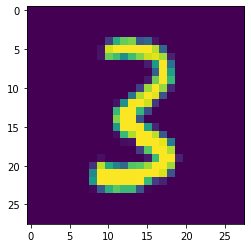

In [151]:
plt.imshow(xb[0].view(28,28))

In [152]:
yb[0]

tensor(3)

In [153]:
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

In [154]:
model, optim = get_model(n_in, nh, n_out)

In [155]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        loss = loss_fun(model(xb), yb)
        loss.backward()
        optim.step()
        optim.zero_grad()

In [156]:
xb, yb = train_ds[:bs]
loss_fun(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1587, grad_fn=<NllLossBackward>), tensor(0.9375))

## Random sampling

# Notes

[^1]: I don't have to define parameters no more, but obviously at first I tried to iniailized Model with `w1, b1, ....`, meaning I didn't practice enough the previous part, part of the torch nn, where I get parameters

[^2]: be cautious since `train_x.sum(-1)` will squeeze the rank, so that you need arg `keepdim:bool`, false as default

[^3]: see *eq (2.46)*, Foundations of Natural Language Processing, Christopher D. Manning and Hinrich Schütze

[^4]: Should check for `cross-entropy $\approx$ softmax of negative likelihood`

[^5]: check later, also you just implemented logsumexp in PyTorch, but you should implement it by yourself.

[^6]: Be careful to take 1 off from size of dataset, in case batch size is divisible number</br>
[^7]: study of hasattr() more<br/>
[^8]: 1) careful, that is in-place function / 2) should learn more of why I need this

[^9]: `parameters` is method, layers is attr. this time we make zero grad to model, not each layer

[^10]: things that happen when you don't specify inheritence

[^11]: (solved) Not sure why I need this condition, but  maybe `_modules` would be involved in key, and want to filter it.<br/> What if i don't filter? -> recursive

[^12]: Why we don't do normalization of train data, in this case? Is that function is embedded in pytorch?

[^13]: (solved) when this dunder is called?, this means they already assigned modules.<br/> maybe at initialization? -> whenever you assign to self

[^14]: what if I don't inherit this?  / What module, and submodule, add submodule functions?

[^15]: (solved) Why do i need to add nn.ReLU() not a functional? -> because setattr filter all the layers automatically so that you don't have to exclude ReLU (basically, ReLU is also layers, only not to having parameters)

[^16]: practice again later